In [1]:
%config IPCompleter.greedy=True

%matplotlib inline
%load_ext autoreload
%autoreload 2

import os
import argparse
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchvision import datasets, transforms, utils
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import numpy as np

from torch.autograd import Variable

import seaborn as sns

import h5py
#import pywt

%pip install pingouin

import pingouin as pg
%pip install matplotlib -U
%pip install Pillow -U

import scipy

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


In [2]:
print(os.getcwd())

/home/ubuntu/Desktop/matt/Shark Behavior Classification


In [3]:
all_data = './datasets/all_data'

paths = [all_data + '/feeding/csv/Feeding_25Hz_',
         all_data + '/swimming/csv/Swimming_25Hz_',
         all_data + '/resting/csv/Resting_25Hz_',
         all_data + '/ndm/csv/NDM_25Hz_']

In [4]:
'''
Load datasets into pandas
'''
dfs = []

for i in range(7):
    df = pd.concat((pd.read_csv(path + str(i+1) + '.csv',
                                index_col=['Date_Time'],
                                parse_dates=['Date_Time'],
                                infer_datetime_format=True) for path in paths), ignore_index=False, sort=False).iloc[:, 1:9]

    
    df = df.replace(to_replace={"Non directed motion": "NDM"})
    
    dfs.append(df)

In [ ]:
static_stats = pd.DataFrame()
dynamic_stats = pd.DataFrame()

static_norms = pd.DataFrame()
dynamic_norms = pd.DataFrame()

for i, df in enumerate(dfs):
    static_stats['Exp ' + str(i+1)] = pd.concat([df[['X_static', 'Y_static', 'Z_static']].max(),
                                                 df[['X_static', 'Y_static', 'Z_static']].min(),
                                                 df[['X_static', 'Y_static', 'Z_static']].mean(),
                                                 df[['X_static', 'Y_static', 'Z_static']].std()], keys=['Max', 'Min', 'Mean', 'Std'])
    
    dynamic_stats['Exp ' + str(i+1)] = pd.concat([df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].max(),
                                                  df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].min(),
                                                  df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].mean(),
                                                  df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].std()], keys=['Max', 'Min', 'Mean', 'Std'])

    static_norms['Exp ' + str(i+1)] = pd.concat([pd.Series(np.linalg.norm(df[['X_static', 'Y_static', 'Z_static']].max())),
                                                 pd.Series(np.linalg.norm(df[['X_static', 'Y_static', 'Z_static']].min())),
                                                 pd.Series(np.linalg.norm(df[['X_static', 'Y_static', 'Z_static']].mean())),
                                                 pd.Series(np.linalg.norm(df[['X_static', 'Y_static', 'Z_static']].std()))], keys=['Max', 'Min', 'Mean', 'Std'])
    
    dynamic_norms['Exp ' + str(i+1)] = pd.concat([pd.Series(np.linalg.norm(df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].max())),
                                                  pd.Series(np.linalg.norm(df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].min())),
                                                  pd.Series(np.linalg.norm(df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].mean())),
                                                  pd.Series(np.linalg.norm(df[['X_dynamic', 'Y_dynamic', 'Z_dynamic']].std()))], keys=['Max', 'Min', 'Mean', 'Std'])

    
    

In [ ]:
static_stats

In [ ]:
dynamic_stats

In [ ]:
static_norms

In [ ]:
dynamic_norms

## Density Estimation for ODBA Distributions

In [5]:
def kde_plot(data_df, feature='ODBA', log_scale=False):
    label_list = data_df['Label'].unique().tolist()
    for label in label_list:
        class_data = data_df.loc[data_df['Label'] == label][feature]

        # Draw the density plot for original data
        ax = sns.kdeplot(data=class_data, legend=True, log_scale=log_scale)

    ax.legend(label_list)

    plt.show()
    plt.clf()

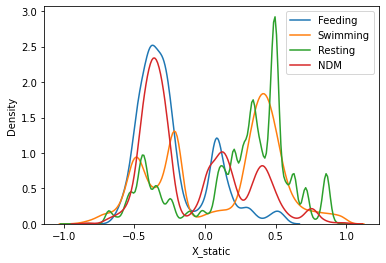

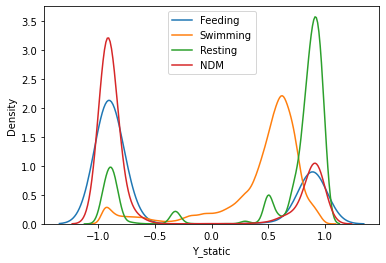

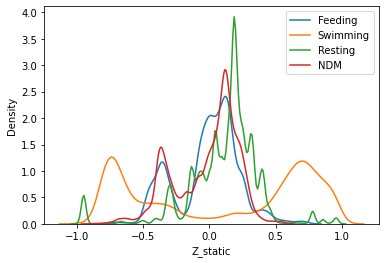

/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:7

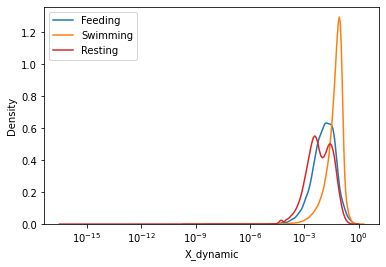

/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:7

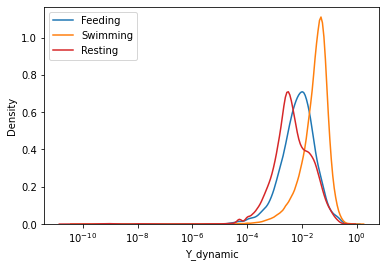

/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: divide by zero encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:726: RuntimeWarning: invalid value encountered in log10
  result = getattr(ufunc, method)(*inputs, **kwargs)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/pandas/core/series.py:7

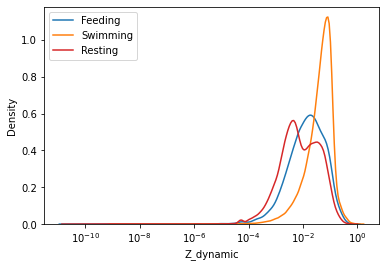

<Figure size 432x288 with 0 Axes>

In [6]:
kde_plot(pd.concat(dfs), feature='X_static')
kde_plot(pd.concat(dfs), feature='Y_static')
kde_plot(pd.concat(dfs), feature='Z_static')
kde_plot(pd.concat(dfs), feature='X_dynamic', log_scale=True)
kde_plot(pd.concat(dfs), feature='Y_dynamic', log_scale=True)
kde_plot(pd.concat(dfs), feature='Z_dynamic', log_scale=True)

In [ ]:
for i, df in enumerate(dfs):
    print("Normality test for Exp " + str(i+1))
    f_data = df.loc[df['Label'] == 'NDM']['X_dynamic']
#     f_data = df[['ODBA']]
#     log_f = np.log10(f_data)
    
#     plt.hist(f_data, bins='auto')
#     plt.show()

#     plt.hist(log_f, bins='auto')
#     plt.show()

#     sm.qqplot(f_data, line ='r')
#     plt.show()
    
#     sm.qqplot(log_f, line ='r')
#     plt.show()
    
    print(scipy.stats.normaltest(f_data))
#     print(scipy.stats.normaltest(log_f))
    
#     print(pg.normality(f_data, alpha=0.05))
#     print(pg.normality(log_f, alpha=0.05))

#     rand_idx = np.random.randint(0,len(df)-5000)
#     print(pg.normality(log_f[rand_idx:rand_idx+5000]), alpha=0.05)
    
#     print(pg.multivariate_normality(df[['X_dynamic', 
#                                         'Y_dynamic', 
#                                         'Z_dynamic']][rand_idx:rand_idx+5000], alpha=0.05))

## Normality Tests

In [ ]:
mean, cov, n = [4, 5], [(0.6, 0.4), (0.4, 0.6)], 5000
x, y = np.random.multivariate_normal(mean, cov, n).T

In [ ]:
print(pg.normality(x))
print(pg.normality(y))
print(pg.multivariate_normality(np.column_stack((x, y))))

In [ ]:
# plt.hist(x, bins='auto')
# plt.show()
# plt.hist(y, bins='auto')
# plt.show()

plt.hist2d(x, y, bins=(69, 69), cmap='gray')
plt.show()

In [ ]:
%pip install statsmodels
import statsmodels.api as sm

In [ ]:
sm.qqplot(y, line ='45')
plt.show()

## Data split

In [7]:
# Train: 1, 2, 3, 4, 7
# Val: 6
# Test: 5
train_df = pd.concat([dfs[0], dfs[1], dfs[2], dfs[3], dfs[6]])
val_df = dfs[5]
test_df = dfs[4]

In [8]:
print(train_df.shape)
print(val_df.shape)
print(test_df.shape)

(1646579, 8)
(77650, 8)
(16775, 8)


In [9]:
features = ['X_static', 'Y_static', 'Z_static', 'X_dynamic', 'Y_dynamic', 'Z_dynamic']

train_data = train_df[features + ['Label']]
val_data = val_df[features + ['Label']]
test_data = test_df[features + ['Label']]

In [10]:
print([df[features].isna().values.any() for df in dfs])
print(train_data[features].isna().values.any())
print(val_data[features].isna().values.any())
print(test_data[features].isna().values.any())

[False, False, False, False, False, False, False]
False
False
False


In [11]:
for column in features:
    mean = np.mean(train_data[column])
    std  = np.std(train_data[column])
    
    train_data[column] = train_data[column].map(lambda x: (x-mean)/std)
    val_data[column]   = val_data[column].map(lambda x: (x-mean)/std)
    test_data[column]  = test_data[column].map(lambda x: (x-mean)/std)

/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/envs/shark-rnn/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the docume

In [12]:
print(np.mean(train_data[features]))
print(np.std(train_data[features]))

print(np.mean(val_data[features]))
print(np.std(val_data[features]))

print(np.mean(test_data[features]))
print(np.std(test_data[features]))

X_static     1.039045e-14
Y_static    -1.001358e-13
Z_static     1.205761e-14
X_dynamic    2.604293e-17
Y_dynamic    3.610452e-17
Z_dynamic    1.876561e-17
dtype: float64
X_static     1.0
Y_static     1.0
Z_static     1.0
X_dynamic    1.0
Y_dynamic    1.0
Z_dynamic    1.0
dtype: float64
X_static    -0.296300
Y_static    -2.296768
Z_static    -1.297910
X_dynamic    0.000275
Y_dynamic   -0.000951
Z_dynamic   -0.000327
dtype: float64
X_static     0.422972
Y_static     0.209462
Z_static     0.345657
X_dynamic    0.964835
Y_dynamic    1.016925
Z_dynamic    1.143621
dtype: float64
X_static    -1.425582
Y_static    -2.124064
Z_static    -0.016430
X_dynamic    0.000889
Y_dynamic   -0.004651
Z_dynamic   -0.003128
dtype: float64
X_static     0.376818
Y_static     0.379074
Z_static     0.764068
X_dynamic    2.443314
Y_dynamic    2.246670
Z_dynamic    2.751217
dtype: float64


In [ ]:
kde_plot(train_data, feature='X_static')
kde_plot(train_data, feature='Y_static')
kde_plot(train_data, feature='Z_static')
kde_plot(train_data, feature='X_dynamic', log_scale=True)
kde_plot(train_data, feature='Y_dynamic', log_scale=True)
kde_plot(train_data, feature='Z_dynamic', log_scale=True)

In [ ]:
kde_plot(val_data, feature='X_static')
kde_plot(val_data, feature='Y_static')
kde_plot(val_data, feature='Z_static')
kde_plot(val_data, feature='X_dynamic', log_scale=True)
kde_plot(val_data, feature='Y_dynamic', log_scale=True)
kde_plot(val_data, feature='Z_dynamic', log_scale=True)

In [ ]:
kde_plot(test_data, feature='X_static')
kde_plot(test_data, feature='Y_static')
kde_plot(test_data, feature='Z_static')
kde_plot(test_data, feature='X_dynamic', log_scale=True)
kde_plot(test_data, feature='Y_dynamic', log_scale=True)
kde_plot(test_data, feature='Z_dynamic', log_scale=True)

## Group contiguous time intervals

In [13]:
def group_times(df):
    time_diff = df.index.to_series().diff()
    breaks = time_diff > pd.Timedelta('1s')
    groups = breaks.cumsum()
    
    df['Group'] = groups
    
    return df

In [14]:
train_data = group_times(train_data)
val_data = group_times(val_data)
test_data = group_times(test_data)

In [30]:
groups = train_data['Group'].unique()
all_groups = set(groups)

decomp = set()
for label in ['Feeding', 'Swimming', 'Resting', 'NDM']:
    fd = train_data[train_data['Label'] == label]
    decomp |= set(fd['Group'].unique())
    
assert(all_groups == decomp)

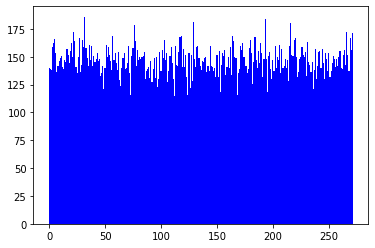

147.05882352941177
12.300325620918448


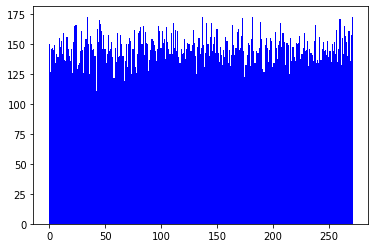

147.05882352941177
11.160437416239532


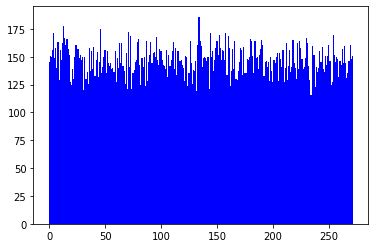

147.05882352941177
12.511620895769115


<Figure size 432x288 with 0 Axes>

In [72]:
from collections import Counter

for i in range(3):
    freqs = {}
    for i in range(40000):
        sample = groups[np.random.randint(len(groups))]
        if sample in freqs.keys():
            freqs[sample] += 1
        else:
            freqs[sample] = 1

    plt.bar(freqs.keys(), freqs.values(), 1, color='b')
    plt.show()
    plt.clf()
    
    print(np.mean(np.array(list(freqs.values()))))
    print(np.std(np.array(list(freqs.values()))))

In [ ]:
def sample_sequences(df, num_samples=None, seq_len=50, dims=1, train=True):
    X = []
    Y = []
    
    label_list = ['Feeding', 'Swimming', 'Resting', 'NDM']
    
    for idx, label in enumerate(label_list):
        print(str(idx) + ": " + label)
        
        class_df = df.loc[df['Label'] == label]
        if train:
            X_class = np.zeros((num_samples, seq_len, dims), dtype=np.float32)
            Y_class = np.full((num_samples, 1), idx, dtype=np.int64)
            
            for i in range(num_samples):
                groups = class_df['Group'].unique()

                chunk_idx = groups[np.random.randint(len(groups))]
                    
                data = class_df.loc[class_df['Group'] == chunk_idx][features].to_numpy()
                
                rand = np.random.randint(len(data)-seq_len)
                
                if dims == 1:
                    X_class[i] = np.expand_dims(data[rand:rand+seq_len], axis=1)
                else:
                    X_class[i] = data[rand:rand+seq_len]
                
        else:
            data = df.loc[df['Label'] == label][features].to_numpy()
            
            num_samples = len(data)//50
            print(num_samples)
            
            X_class = np.zeros((num_samples, seq_len, dims), dtype=np.float32)
            Y_class = np.full((num_samples, 1), idx, dtype=np.int64)
            
            for i in range(num_samples):
                if dims == 1:
                    X_class[i] = np.expand_dims(data[seq_len*i:seq_len*(i+1)], axis=1)
                else:
                    X_class[i] = data[seq_len*i:seq_len*(i+1)]
                    
        X.append(X_class)
        Y.append(Y_class)
        
    return np.concatenate(X), np.concatenate(Y)

In [59]:
X_train, Y_train = sample_sequences(train_data, num_samples=10000, dims=6)

0: Feeding
1: Swimming
2: Resting
3: NDM


In [62]:
from sklearn.utils import shuffle

X_train, Y_train = shuffle(X_train, Y_train, random_state=33)

In [63]:
X_train

array([[[-1.44526196e+00,  6.01968944e-01, -1.25435978e-01,
          3.61848652e-01,  4.82883215e-01,  1.00672174e+00],
        [-1.44577408e+00,  6.01541400e-01, -1.26112103e-01,
          2.75965780e-01,  2.48849168e-01,  1.10699487e+00],
        [-1.44628382e+00,  6.01112247e-01, -1.26653463e-01,
          9.93255675e-02,  1.37387067e-01,  1.01806402e+00],
        ...,
        [-1.45759797e+00,  6.01189554e-01, -1.16427727e-01,
          2.34314296e-02,  1.35957435e-01, -5.83235443e-01],
        [-1.45810521e+00,  6.01189554e-01, -1.17641866e-01,
          1.21354550e-01,  2.55424470e-01, -5.71924508e-01],
        [-1.45848572e+00,  6.01189554e-01, -1.19124748e-01,
          2.15740278e-01,  3.77954155e-01, -5.58109939e-01]],

       [[-1.18518364e+00, -2.42656112e+00, -2.88803637e-01,
         -1.20722890e-01, -5.33933826e-02, -1.35273309e-02],
        [-1.18480313e+00, -2.42656112e+00, -2.89745152e-01,
          5.71581237e-02, -5.33933826e-02, -9.87327769e-02],
        [-1.18416

In [ ]:
X_val, Y_val = sample_sequences(val_data, num_samples=2000, dims=6)

In [ ]:
X_val, Y_val = shuffle(X_val, Y_val, random_state=33)

In [ ]:
print(X_train.mean())
print(X_train.std())

print(X_val.mean())
print(X_val.std())

In [ ]:
from collections import Counter

print(Counter(np.squeeze(Y_train).tolist()))
print(Counter(np.squeeze(Y_val).tolist()))

In [ ]:
test_data.count()

In [ ]:
X_test, Y_test = sample_sequences(test_data, train=False, dims=6)

In [ ]:
print(X_test.shape)
print(Y_test.shape)

In [ ]:
test_odba['Label'].value_counts()//50

In [ ]:
sum(test_odba['Label'].value_counts()//50)

In [ ]:
## This estimates the distribution of each sequence (40,000/2,000 distributions, each of 50 samples)
ax = sns.kdeplot(data=np.squeeze(X_train).T, legend=False)

plt.show()
plt.clf()

ax = sns.kdeplot(data=np.squeeze(X_val).T, legend=False)

plt.show()
plt.clf()

In [ ]:
## This estimates the distribution of each sequence element (50 distributions, each of 40,000/2,000 samples)
ax = sns.kdeplot(data=np.squeeze(X_train), legend=False)

plt.show()
plt.clf()

ax = sns.kdeplot(data=np.squeeze(X_val), legend=False)

plt.show()
plt.clf()

In [ ]:
## This estimates the distribution over the train and val sets, respectively
ax = sns.kdeplot(data=train_odba['ODBA'], legend=False)

plt.show()
plt.clf()

ax = sns.kdeplot(data=val_odba['ODBA'], legend=False)

plt.show()
plt.clf()

In [ ]:
ax = sns.kdeplot(data=X_train.flatten(), legend=False)

plt.show()
plt.clf()

ax = sns.kdeplot(data=X_val.flatten(), legend=False)

plt.show()
plt.clf()

In [ ]:
def write(data, gts, outfile):
    '''
        This function writes the pre-processed image data to a HDF5 file
        Args:
          data: numpy.array, image data as numpy array
          outfile: string, path to write file to
    '''
    print("---------------------------------------")
    print("Saving data")
    print("---------------------------------------\n")
    with h5py.File(outfile, "w") as f:
        f.create_dataset("features", data=data, dtype=data.dtype)
        f.create_dataset("gts", data=gts, dtype=gts.dtype)

def load(infile, dataset):
    '''
        This function loads the image data from a HDF5 file 
        Args:
          outfile: string, path to read file from
          
        Returns:
          f["image"][()]: numpy.array, image data as numpy array
    '''
    print("---------------------------------------")
    print("Loading data")
    print("---------------------------------------\n")
    with h5py.File(infile, "r") as f:
        return f[dataset][()]

In [ ]:
write(X_train, Y_train, './datasets/data/2d/train/data.hdf5')
write(X_val, Y_val, './datasets/data/2d/val/data.hdf5')
write(X_test, Y_test, './datasets/data/2d/test/orig/data.hdf5')

In [ ]:
X_train